# EDA using HeatMaps
This notebook explores the GDP and CO2 emissions datasets contained in `..\data\final`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
os.makedirs('../plots/heatmaps', exist_ok=True)

In [2]:
df = pd.read_csv('../data/final/gdp_co2_emissions.csv')

 ---

Quick inspection

In [3]:
df.head()

,Country Name,Country Code,Continent,Year,CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %),log (GDP pc),log (CO2 pc)
0,Afghanistan,AFG,Asia,2000,1047127.94,0.052017,6.206548e+09,1617.826475,NaN,7.388839,-2.956177
1,Afghanistan,AFG,Asia,2001,1069098.00,0.052706,5.621148e+09,1454.110782,-9.431974,7.282150,-2.943032
2,Afghanistan,AFG,Asia,2002,1341065.00,0.062731,7.228796e+09,1774.308743,28.600001,7.481166,-2.768904
3,Afghanistan,AFG,Asia,2003,1559679.00,0.068608,7.867263e+09,1815.928200,8.832278,7.504352,-2.679340
4,Afghanistan,AFG,Asia,2004,1237247.00,0.052513,7.978516e+09,1776.918207,1.414118,7.482636,-2.946689


In [4]:
df.describe()

,Year,CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %),log (GDP pc),log (CO2 pc)
count,6654.000000,6.654000e+03,6654.000000,6.654000e+03,6654.000000,6629.000000,6654.000000,6654.000000
mean,2007.170875,1.525537e+08,4.993185,3.205916e+11,21417.620234,3.362959,9.348655,0.653466
std,10.055182,7.156620e+08,8.061876,1.420625e+12,23875.731064,6.913057,1.195782,1.618282
min,1990.000000,3.664000e+03,0.020765,2.156211e+07,510.822823,-64.047107,6.236023,-3.874476
25%,1999.000000,1.509484e+06,0.663668,4.872798e+09,4378.720502,1.202115,8.384512,-0.409974
50%,2007.000000,8.725938e+06,2.571025,2.083318e+10,12336.843581,3.603829,9.420345,0.944304
75%,2016.000000,5.883844e+07,6.796044,1.425411e+11,30764.538671,5.919124,10.334118,1.916341
max,2024.000000,1.228904e+10,364.790830,2.256846e+13,174569.523171,149.972963,12.070078,5.899324


 ---
## Heatmap Correlation
Plotting **Heatmaps** between GDP and CO2 emissions among 3 time ranges. The heatmap allows to visualize how each variable interact. 

As expected, the plots show strong evidence (usually 0.8 - 1 correlation) that the Total `GDP` and `CO2 emissions` are related, whereas, interestingly, `GDP per capita` and `CO2 per capita` correlation seems more moderate (usually 0.4-0.8 correlation). This mean that individual wealth doesn't necessary lead to higher pollution, suggesting that technological, energetic or cultural differences between countries also play an important role.

It can also be seen that the annual growth of a country is not a good predictor for CO2 emissions (approx 0 correlation), thus the _rate_ at which an economy grows in a single year doesn't have a significative environmental impact. This variable is hence removed from the dataset for the next steps.

In [5]:
# Columns for correlation
numeric_cols = ['CO2 emissions', 'CO2 emissions per capita', 'log (CO2 pc)',
                'GDP', 'GDP per capita', 'log (GDP pc)', 'GDP growth (annual %)']
short_names = {'CO2 emissions': 'CO2', 'CO2 emissions per capita': 'CO2 pc', 
              'GDP': 'GDP', 'GDP per capita': 'GDP pc', 'GDP growth (annual %)': 'GDP growth'}

num_ranges = 3

min_year = df['Year'].min()
max_year = df['Year'].max()

In [6]:
def create_correlation_heatmaps(data, title, output_path, filter_condition=None, figsize=(20, 6), short_names=None):
    """
    Create correlation heatmaps across multiple time ranges
    
    Parameters:
    - data: DataFrame with the data to analyze
    - title: Title for the figure
    - output_path: Path to save the figure
    - filter_condition: Optional filtering function (applied before time range filtering)
    - figsize: Figure size (default: (20, 6))
    - short_names: Dictionary to shorten column names (optional)
    """

    # Apply filter if provided
    if filter_condition is not None:
        df_filtered = filter_condition(data).copy()
    else:
        df_filtered = data.copy()
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, num_ranges, figsize=figsize)
    
    for i in range(num_ranges):
        range_start = min_year + i * (max_year - min_year) // num_ranges
        range_end = min_year + (i + 1) * (max_year - min_year) // num_ranges
        
        # Filter by time range and calculate mean values for each country
        df_subset = df_filtered[(df_filtered['Year'] > range_start) & 
                                (df_filtered['Year'] <= range_end)]
        df_subset = df_subset.groupby('Country Code')[numeric_cols].mean().reset_index()
        
        # Calculate correlation matrix
        correlation_matrix = df_subset[numeric_cols].corr()
        
        # Apply short names if provided
        if short_names is not None:
            correlation_matrix.index = [short_names.get(col, col) for col in correlation_matrix.index]
            correlation_matrix.columns = [short_names.get(col, col) for col in correlation_matrix.columns]
        
        # Create heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                    ax=axes[i], vmin=-1, vmax=1, fmt=".2f", cbar_kws={'shrink': 0.8})
        axes[i].set_title(f'{range_start}-{range_end}', fontsize=12, fontweight='bold')
    
    fig.suptitle(title, fontsize=16, y=0.995)
    fig.tight_layout()
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


### 1. Correlation Heatmap all countries


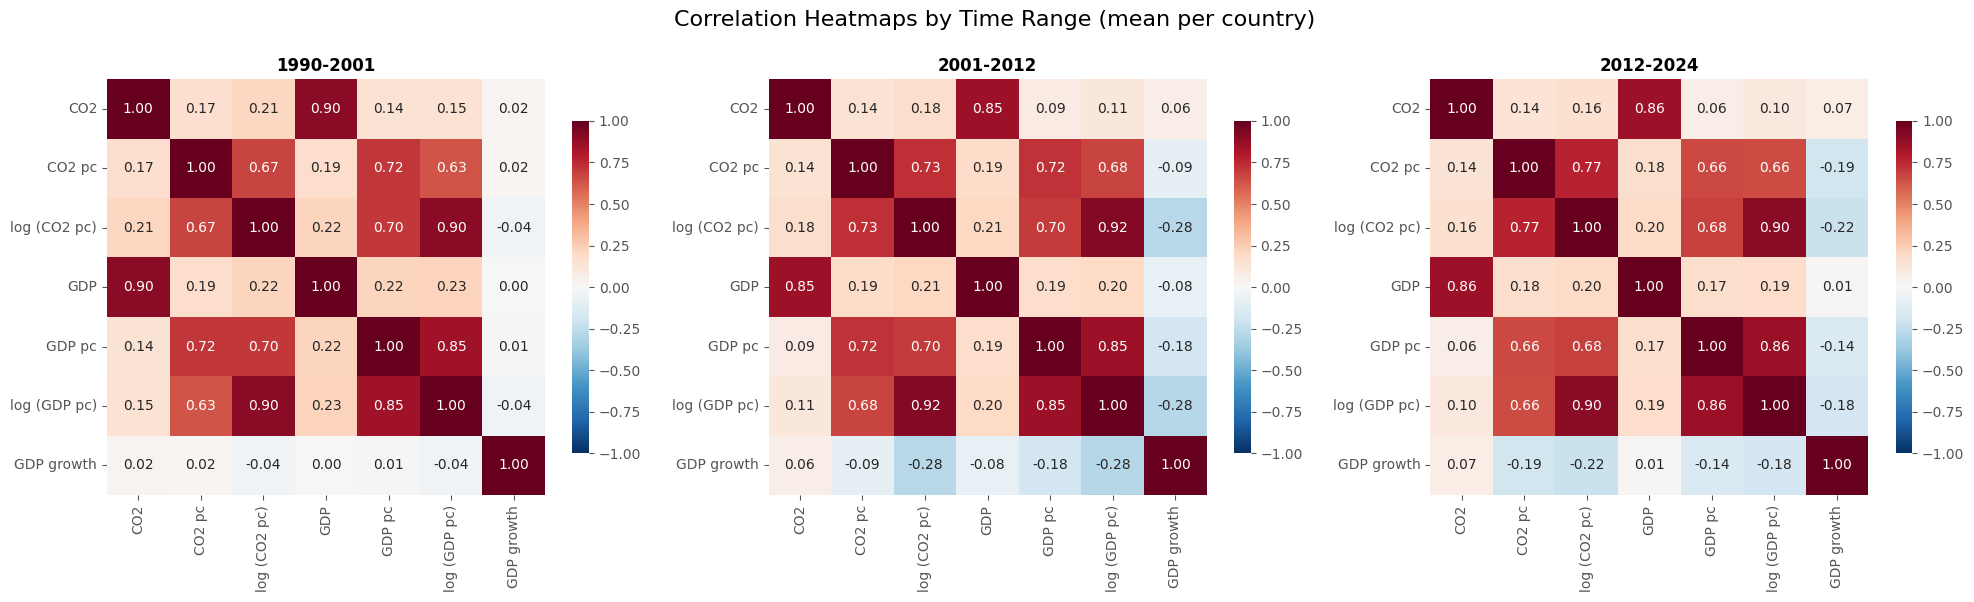

In [7]:
create_correlation_heatmaps(
    data=df,
    title='Correlation Heatmaps by Time Range (mean per country)',
    output_path='../plots/heatmaps/heatmap_gdp_co2.png',
    short_names=short_names
)

 ---
### 2. Correlation Heatmaps across all continents

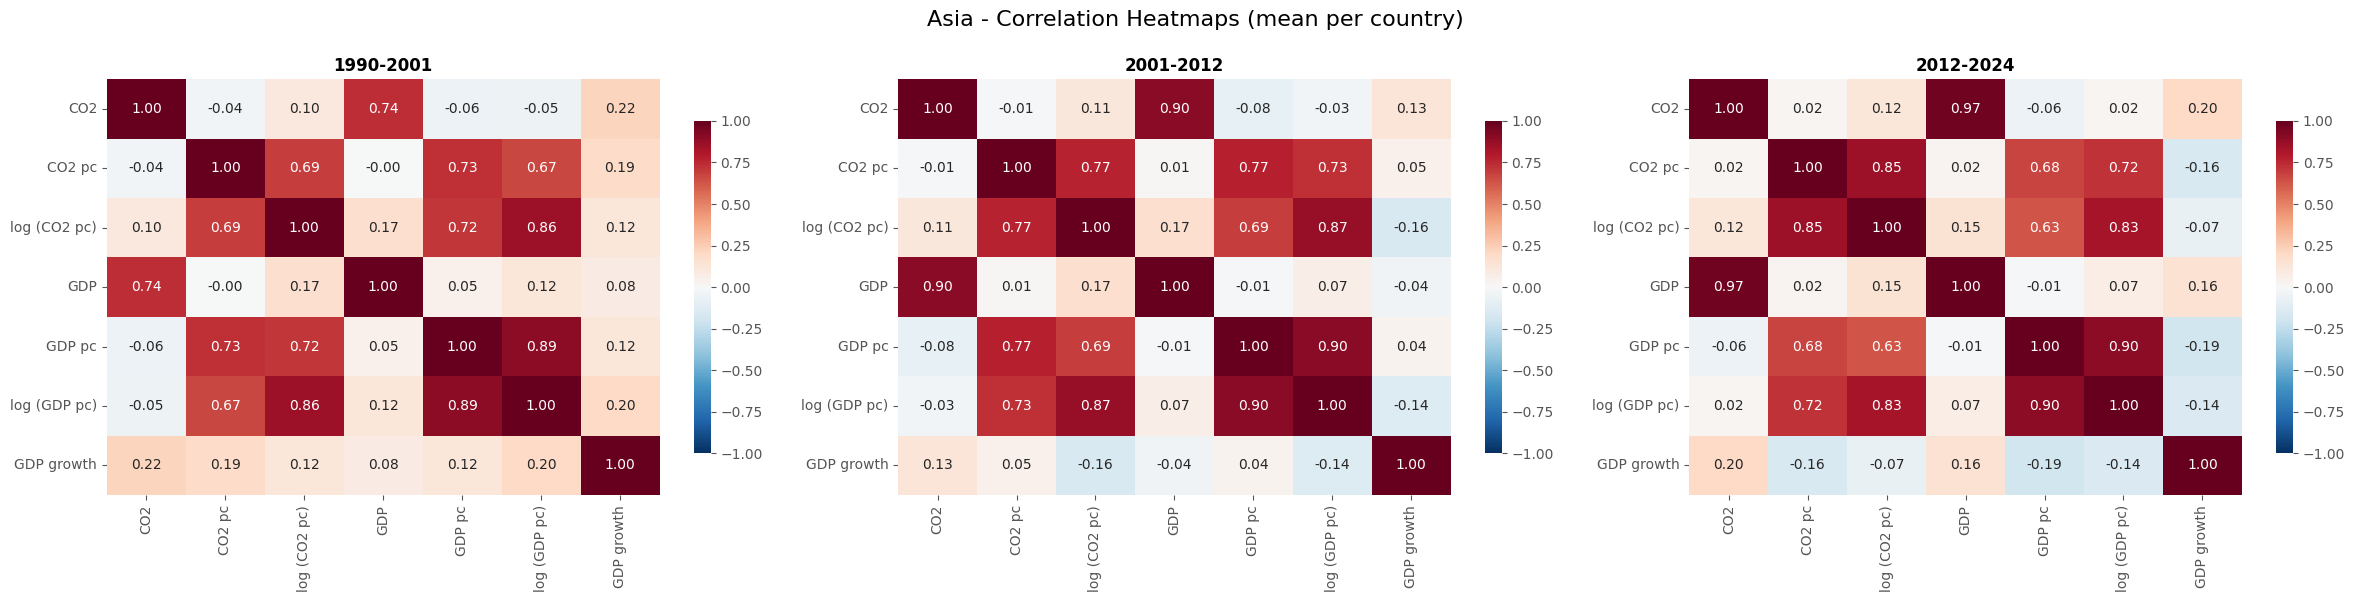

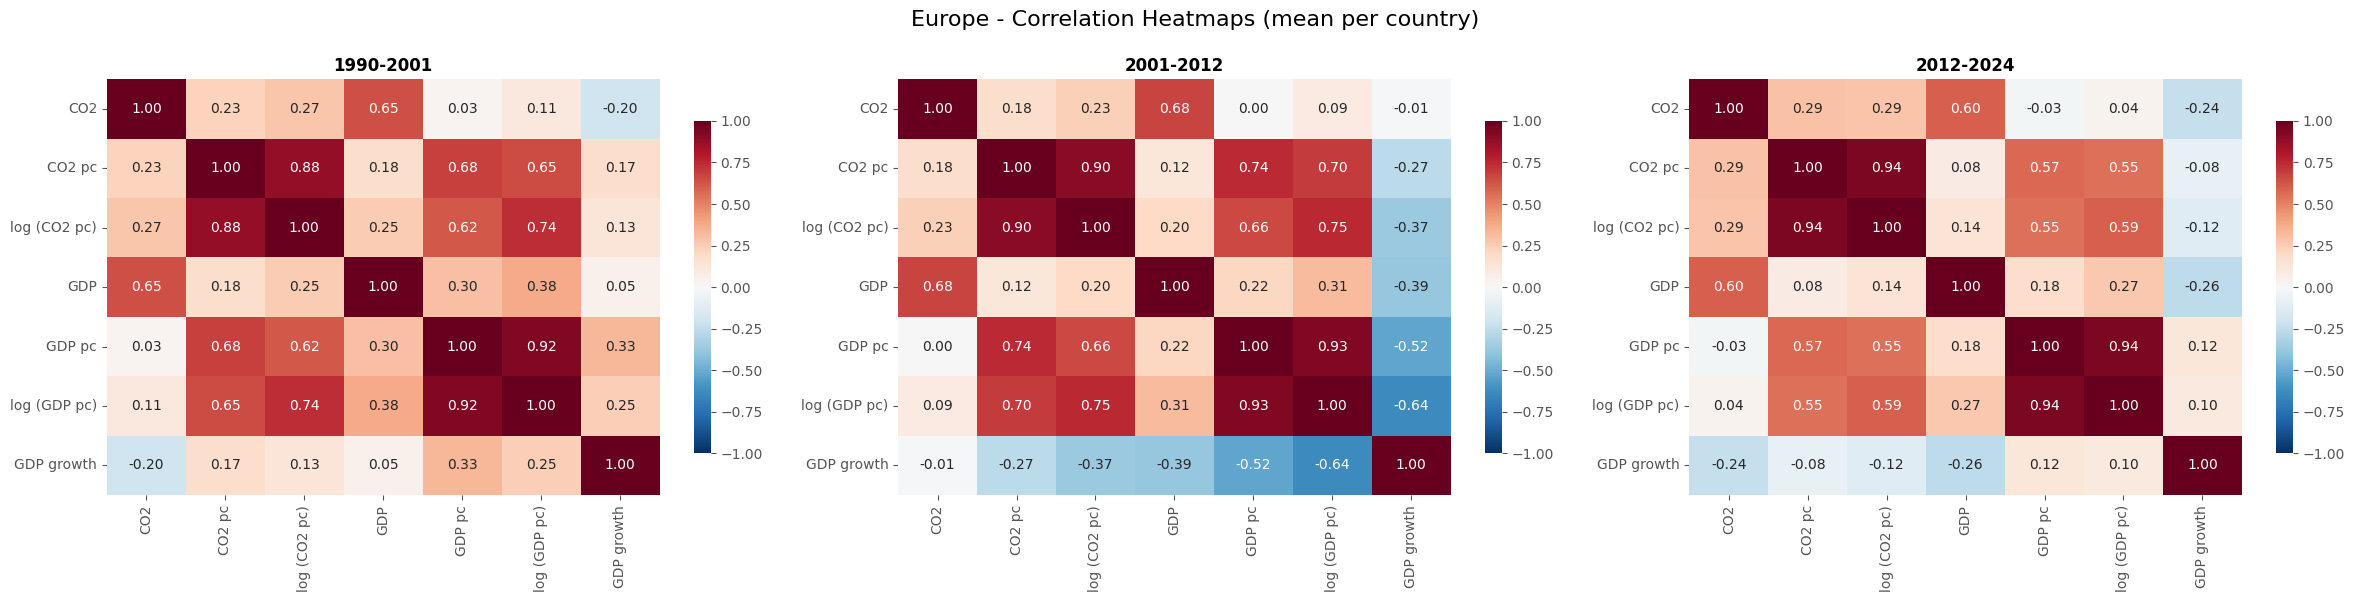

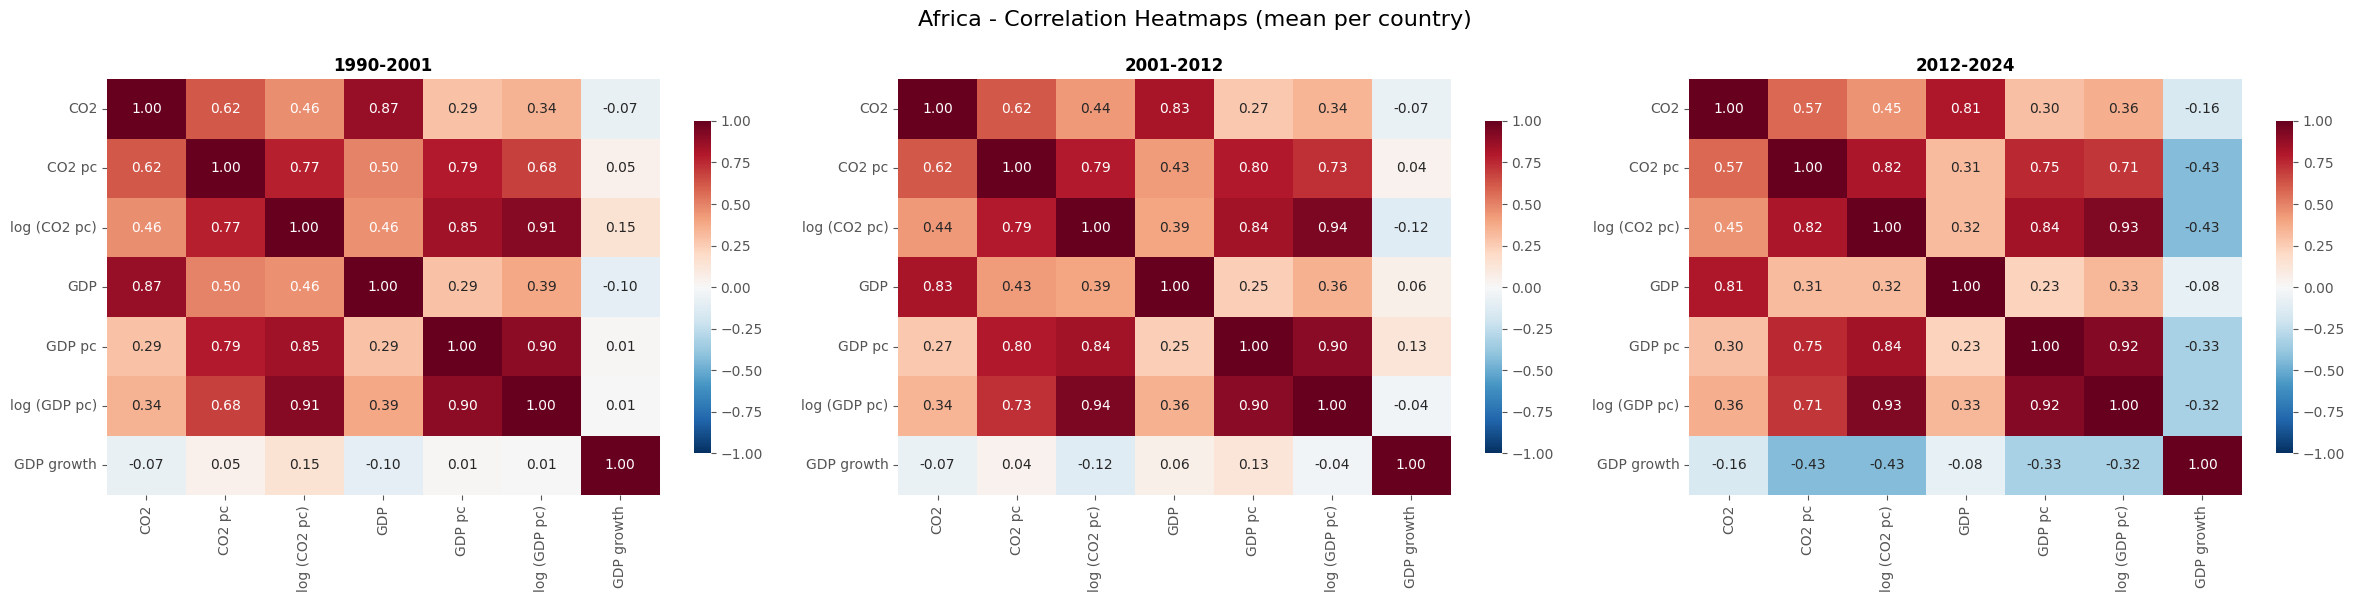

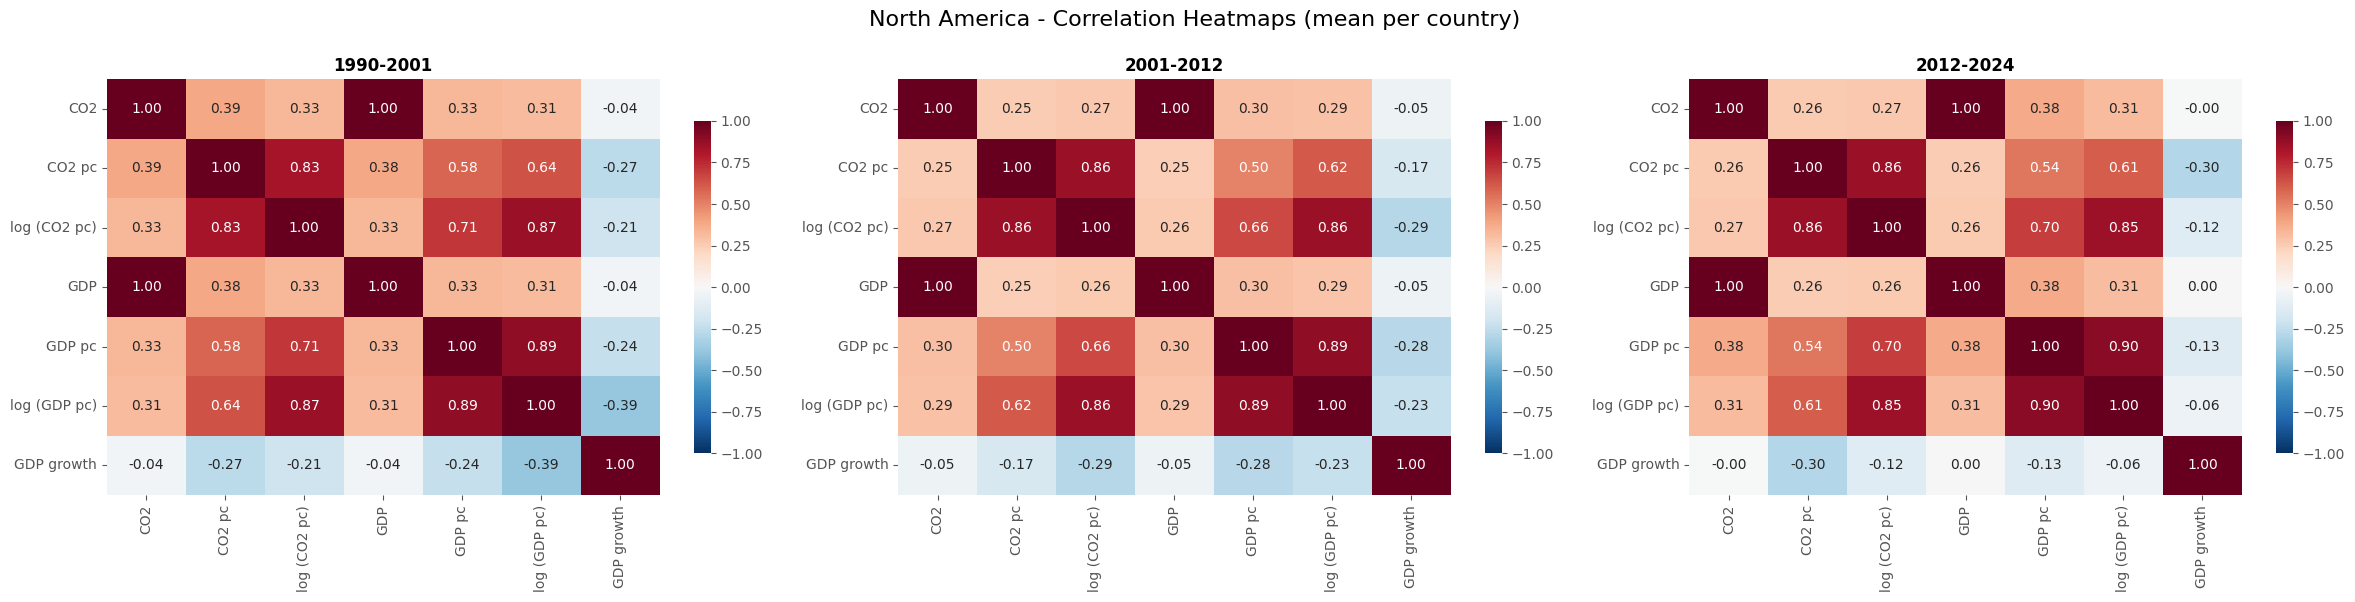

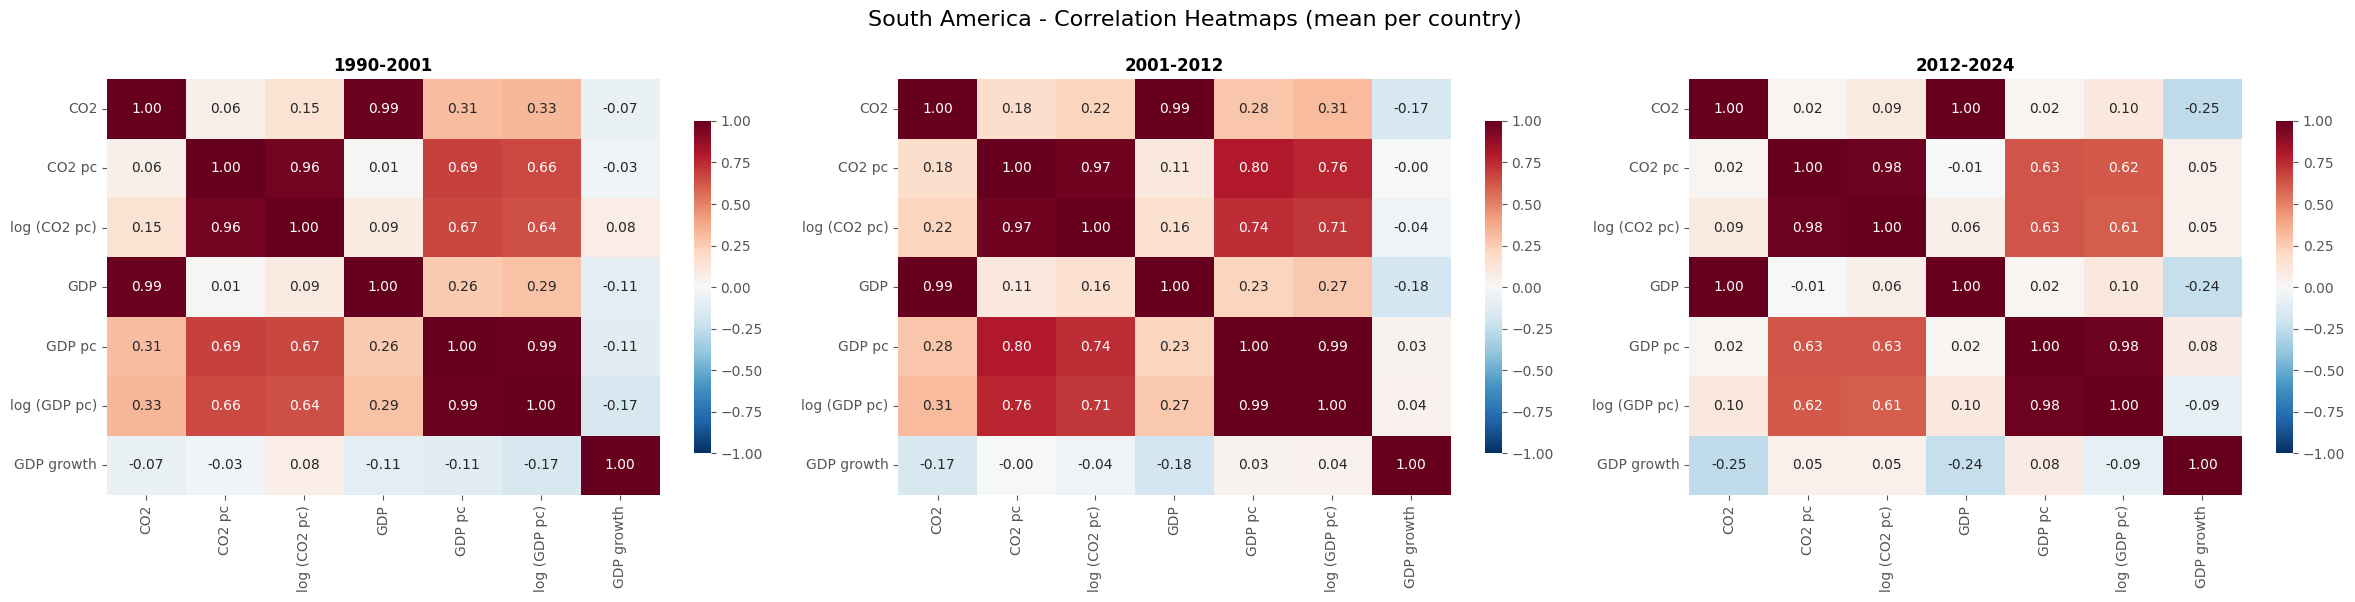

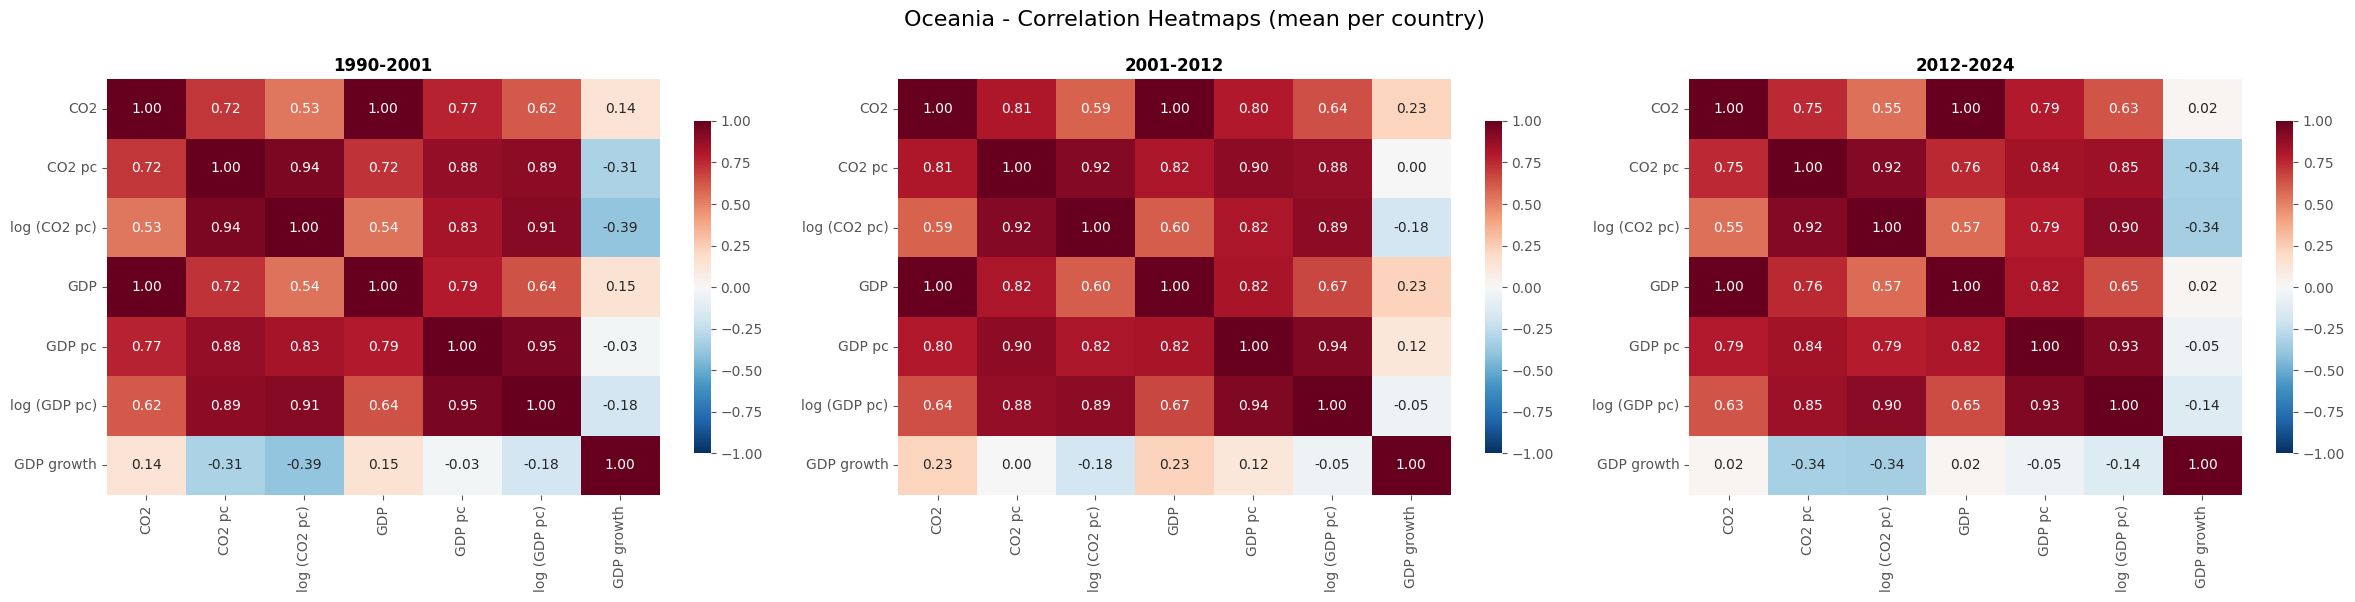

In [8]:
continents = df['Continent'].unique()
continents = [c for c in continents if pd.notna(c)]  # Exclude NaN values

for continent in continents:
    # Function to filter by continent
    def filter_continent(data, cont=continent):
        return data[data['Continent'] == cont]
    
    create_correlation_heatmaps(
        data=df,
        title=f'{continent} - Correlation Heatmaps (mean per country)',
        output_path=f'../plots/heatmaps/heatmap_{continent.lower().replace(" ", "_")}.png',
        filter_condition=lambda d, c=continent: filter_continent(d, c),
        figsize=(24, 6),
        short_names=short_names
    )


From these heatmaps we can say that:
- Annual GDP growth is not useful for our analysis hence can be removed
- GDP pc and CO2 pc should be log transformed
 